# Import Library

In [44]:
# tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Activation, Add, BatchNormalization, Conv2D, Flatten, Dense, DepthwiseConv2D, Dropout, GlobalAveragePooling2D, Input, Layer, MaxPool2D, MaxPooling2D, Multiply, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau

# system libraries
import os
import random
from pathlib import Path

# visualization libraries
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, make_scorer
from sklearn.model_selection import train_test_split

In [2]:
# Define constants
DATASET_PATH = "C:\\Users\\User\\Downloads\\FYP-test\\condition_ds\\"
BATCH_SIZE = 32
EPOCHS = 20
TARGET_SIZE = (224, 224)

# Helper function

In [3]:
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [4]:
def load_dataset(file):
    data = []
    class_labels = []
    for label, class_folder in enumerate(os.listdir(file)):
        class_labels.append(class_folder)
        class_path = os.path.join(file, class_folder)
        if os.path.isdir(class_path):
            for image_file in os.listdir(class_path):
                image_path = os.path.join(class_path, image_file)
                # Append (file_path, label) tuple to data list
                data.append((image_path, label))
    return data, class_labels

In [5]:
# Walk through each directory for apple conditions
walk_through_dir(DATASET_PATH)

There are 2 directories and 0 images in 'C:\Users\User\Downloads\FYP-test\condition_ds\'.
There are 0 directories and 911 images in 'C:\Users\User\Downloads\FYP-test\condition_ds\fresh'.
There are 0 directories and 912 images in 'C:\Users\User\Downloads\FYP-test\condition_ds\rotten'.


In [6]:
image, labels = load_dataset(DATASET_PATH)
print(image)
print(labels)

[('C:\\Users\\User\\Downloads\\FYP-test\\condition_ds\\fresh\\fresh (1).jpg', 0), ('C:\\Users\\User\\Downloads\\FYP-test\\condition_ds\\fresh\\fresh (1).png', 0), ('C:\\Users\\User\\Downloads\\FYP-test\\condition_ds\\fresh\\fresh (10).jpg', 0), ('C:\\Users\\User\\Downloads\\FYP-test\\condition_ds\\fresh\\fresh (10).png', 0), ('C:\\Users\\User\\Downloads\\FYP-test\\condition_ds\\fresh\\fresh (100).jpg', 0), ('C:\\Users\\User\\Downloads\\FYP-test\\condition_ds\\fresh\\fresh (100).png', 0), ('C:\\Users\\User\\Downloads\\FYP-test\\condition_ds\\fresh\\fresh (101).jpg', 0), ('C:\\Users\\User\\Downloads\\FYP-test\\condition_ds\\fresh\\fresh (101).png', 0), ('C:\\Users\\User\\Downloads\\FYP-test\\condition_ds\\fresh\\fresh (102).jpg', 0), ('C:\\Users\\User\\Downloads\\FYP-test\\condition_ds\\fresh\\fresh (102).png', 0), ('C:\\Users\\User\\Downloads\\FYP-test\\condition_ds\\fresh\\fresh (103).jpg', 0), ('C:\\Users\\User\\Downloads\\FYP-test\\condition_ds\\fresh\\fresh (103).png', 0), ('C:\\Use

# Data Visualization

In [7]:
image_dir = Path(DATASET_PATH)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png'))

condition_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)

condition_labels = pd.Series(condition_labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, condition_labels], axis=1)

print(condition_labels)

0        fresh
1        fresh
2        fresh
3        fresh
4        fresh
         ...  
1818    rotten
1819    rotten
1820    rotten
1821    rotten
1822    rotten
Name: Label, Length: 1823, dtype: object


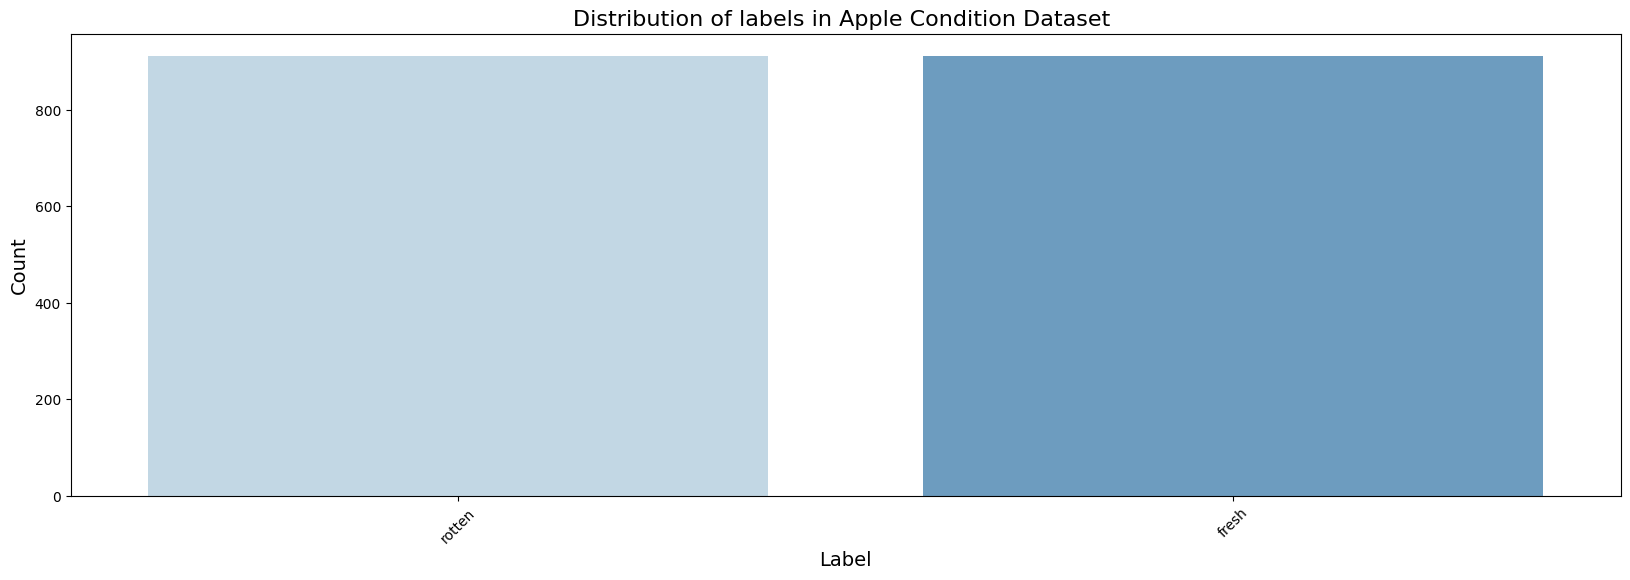

In [8]:
label_counts = image_df['Label'].value_counts()[:20]

plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='Blues')
plt.title('Distribution of labels in Apple Condition Dataset ', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

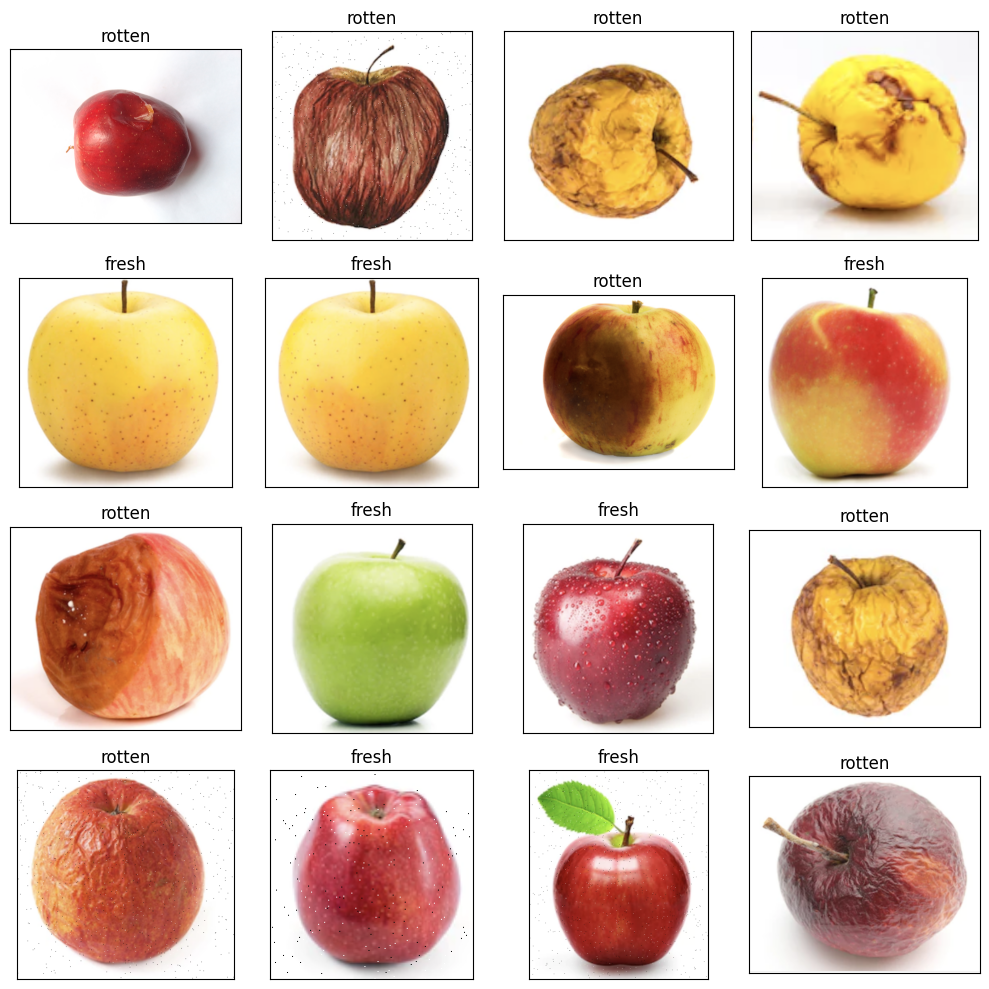

In [9]:
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()


# Data Preprocessing

In [10]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [11]:
# Set up data generators for training, validation, and testing
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Rescale pixel values to [0, 1]
    validation_split=0.2,       # Split 20% of the data for validation
    rotation_range=15,          # Randomly rotate images by up to 20 degrees
    width_shift_range=0.1,      # Randomly shift images horizontally by up to 10%
    height_shift_range=0.1,     # Randomly shift images vertically by up to 10%
    shear_range=0.1,            # Apply shear transformation with intensity up to 10%
    zoom_range=0.1,             # Randomly zoom into images by up to 10%
    horizontal_flip=True,       # Randomly flip images horizontally
    fill_mode='nearest'         # Strategy for filling in newly created pixels after rotation or shifting
)


# Create a generator for training data
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',  # Column containing the file paths
    y_col='Label',     # Column containing the labels
    target_size=TARGET_SIZE,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='binary',  # For binary classification
    shuffle=True,  # Shuffle the data
    seed=42,
    subset='training'
)

# Create a generator for validation data
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',  # Column containing the file paths
    y_col='Label',     # Column containing the labels
    target_size=TARGET_SIZE,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='binary',  # For binary classification
    shuffle=True,  # Shuffle the data
    seed=42,
    subset='validation'
)

# Create a generator for testing data (if needed)
test_generator = train_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',  # Column containing the file paths
    y_col='Label',     # Column containing the labels
    target_size=TARGET_SIZE,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='binary',  # For binary classification
    shuffle=False  # No need to shuffle for testing
)

# Display the class indices
print("Class Indices:", train_generator.class_indices)

# Display the number of samples in each split
print("Number of training samples:", train_generator.samples)
print("Number of validation samples:", validation_generator.samples)
print("Number of testing samples:", test_generator.samples)

Found 1167 validated image filenames belonging to 2 classes.
Found 291 validated image filenames belonging to 2 classes.
Found 365 validated image filenames belonging to 2 classes.
Class Indices: {'fresh': 0, 'rotten': 1}
Number of training samples: 1167
Number of validation samples: 291
Number of testing samples: 365


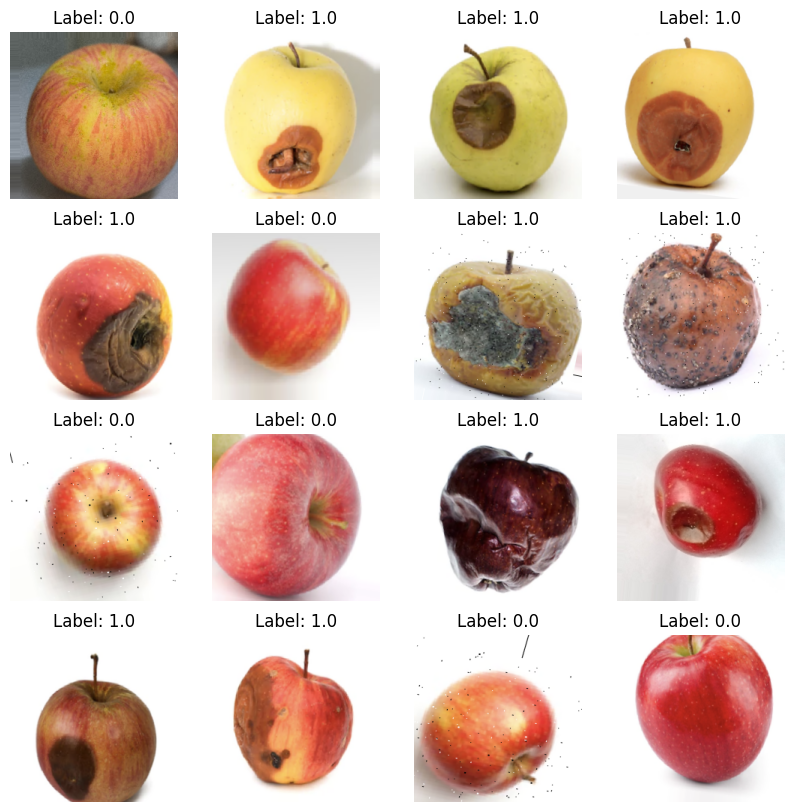

In [12]:
# Fetch a batch of images and labels from the data generator
x_batch, y_batch = next(train_generator)

# Visualize the first few images and their labels
plt.figure(figsize=(10, 10))
for i in range(min(16, len(x_batch))):  # Visualize up to 16 images
    plt.subplot(4, 4, i + 1)
    plt.imshow(x_batch[i])
    plt.title('Label: ' + str(y_batch[i]))
    plt.axis('off')
plt.show()

In [13]:
print(y_batch)

[0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 0. 0. 0.]


# Define Model

## Model 1: custom CNN

In [116]:
# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax') 
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 26, 26, 128)     

## Model 2: MobileNet V2

In [123]:
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights=None)

# Freeze the base model
base_model.trainable = False

model2_1 = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    # tf.keras.layers.Dense(768, activation='relu'),
    # tf.keras.layers.Dense(768, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')  # Adjust the number of units to match the number of classes
])

model2_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model2_1.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_7  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_19 (Dense)            (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


## Model 3: Pre-trained MobileNetV2

In [103]:
# Define the MobileNetV2 model with pre-trained weights from ImageNet
pretrained_mobilenetv2 = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the weights of the pre-trained layers
pretrained_mobilenetv2.trainable = False

# Add a custom classification head on top of the pre-trained model
model2_2 = tf.keras.models.Sequential([
    pretrained_mobilenetv2,
    tf.keras.layers.GlobalAveragePooling2D(),
    # tf.keras.layers.Dense(768, activation='relu'),
    # tf.keras.layers.Dense(768, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')  # Adjusted number of units
])

# Compile the model
model2_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model2_2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_5  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_14 (Dense)            (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


# Model Training

## Model 1: Custom CNN

In [117]:
callbacks = [
    EarlyStopping(patience=5, monitor='val_loss', verbose=1),
    ModelCheckpoint('custom_CNN_condition.h5', save_best_only=True, monitor='val_loss', mode='min'),  
    ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.00001, verbose=1),
]

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch= train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/20
36/36 [==============================] - ETA: 0s - loss: 0.9643 - accuracy: 0.5225

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 40s 1s/step - loss: 0.9643 - accuracy: 0.5225 - val_loss: 0.6910 - val_accuracy: 0.4722 - lr: 0.0010
Epoch 2/20
36/36 [==============================] - 34s 949ms/step - loss: 0.6334 - accuracy: 0.6388 - val_loss: 0.5801 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 3/20
36/36 [==============================] - 54s 1s/step - loss: 0.4900 - accuracy: 0.7868 - val_loss: 0.3828 - val_accuracy: 0.8403 - lr: 0.0010
Epoch 4/20
36/36 [==============================] - 35s 963ms/step - loss: 0.3969 - accuracy: 0.8203 - val_loss: 0.3087 - val_accuracy: 0.8715 - lr: 0.0010
Epoch 5/20
36/36 [==============================] - 33s 906ms/step - loss: 0.4131 - accuracy: 0.8238 - val_loss: 0.2461 - val_accuracy: 0.8993 - lr: 0.0010
Epoch 6/20
36/36 [==============================] - 31s 873ms/step - loss: 0.3375 - accuracy: 0.8502 - val_loss: 0.2466 - val_accuracy: 0.8785 - lr: 0.0010
Epoch 7/20
36/36 [==============================] - ETA: 0s - loss: 0.3215 - accu

## Model 2: MobileNet V2

In [124]:
callbacks = [
    EarlyStopping(patience=5, monitor='val_loss', verbose=1),
    ModelCheckpoint('MobileNetV2_condition2_1.h5', save_best_only=True, monitor='val_loss', mode='min') 
    # ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.00001, verbose=1),
]

# Train the model
history = model2_1.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks
)


Epoch 1/20
36/36 [==============================] - 25s 623ms/step - loss: 0.6932 - accuracy: 0.4960 - val_loss: 0.6933 - val_accuracy: 0.4722
Epoch 2/20


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 22s 605ms/step - loss: 0.6931 - accuracy: 0.5113 - val_loss: 0.6936 - val_accuracy: 0.4757
Epoch 3/20
36/36 [==============================] - 22s 613ms/step - loss: 0.6931 - accuracy: 0.5145 - val_loss: 0.6942 - val_accuracy: 0.4653
Epoch 4/20
36/36 [==============================] - 22s 596ms/step - loss: 0.6929 - accuracy: 0.5137 - val_loss: 0.6943 - val_accuracy: 0.4688
Epoch 5/20
36/36 [==============================] - 22s 606ms/step - loss: 0.6930 - accuracy: 0.5101 - val_loss: 0.6944 - val_accuracy: 0.4688
Epoch 6/20
36/36 [==============================] - 23s 650ms/step - loss: 0.6930 - accuracy: 0.5093 - val_loss: 0.6944 - val_accuracy: 0.4688
Epoch 6: early stopping


## Model 3: Pre-trained MobileNet V2

In [104]:
callbacks = [
    EarlyStopping(patience=5, monitor='val_loss', verbose=1),
    ModelCheckpoint('MobileNetV2_condition2_69.h5', save_best_only=True, monitor='val_loss', mode='min') 
    # ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.00001, verbose=1),
]

# Train the model
history = model2_2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks
)


Epoch 1/20
36/36 [==============================] - 30s 795ms/step - loss: 0.4217 - accuracy: 0.8009 - val_loss: 0.2350 - val_accuracy: 0.9097
Epoch 2/20
36/36 [==============================] - 26s 734ms/step - loss: 0.1896 - accuracy: 0.9374 - val_loss: 0.1593 - val_accuracy: 0.9479
Epoch 3/20
36/36 [==============================] - 26s 711ms/step - loss: 0.1311 - accuracy: 0.9674 - val_loss: 0.1459 - val_accuracy: 0.9514
Epoch 4/20
36/36 [==============================] - 25s 704ms/step - loss: 0.1106 - accuracy: 0.9736 - val_loss: 0.1222 - val_accuracy: 0.9549
Epoch 5/20
36/36 [==============================] - 25s 693ms/step - loss: 0.0966 - accuracy: 0.9727 - val_loss: 0.1130 - val_accuracy: 0.9653
Epoch 6/20
36/36 [==============================] - 25s 690ms/step - loss: 0.0815 - accuracy: 0.9789 - val_loss: 0.0921 - val_accuracy: 0.9722
Epoch 7/20
36/36 [==============================] - 25s 690ms/step - loss: 0.0700 - accuracy: 0.9815 - val_loss: 0.1109 - val_accuracy: 0.9479

# Model Evaluation

## Model 1: Custom CNN

In [118]:
# Evaluate the trained model on the test set (run this when already done training)
model1 = load_model('custom_CNN_condition.h5')
test_loss, test_accuracy = model1.evaluate(test_generator)

# # Evaluate the model on the test set
# test_loss, test_accuracy = model.evaluate(test_generator)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

12/12 [==============================] - 5s 401ms/step - loss: 0.1953 - accuracy: 0.9288
Test Loss: 0.19526790082454681
Test Accuracy: 0.9287671446800232


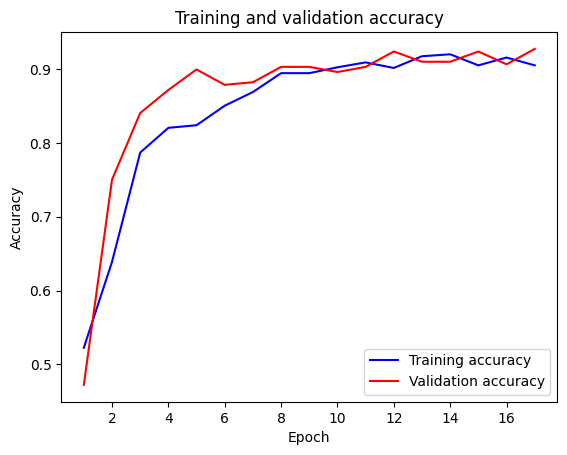

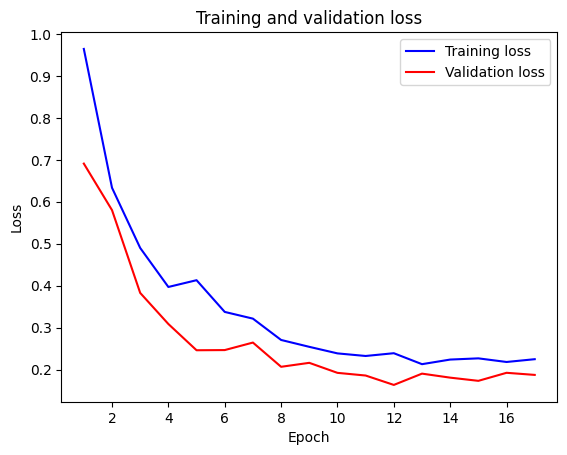

In [119]:
# Extracting training and validation accuracy and loss
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']


loss = history.history['loss']
val_loss = history.history['val_loss']


# Calculating the number of epochs
epochs = range(1, len(accuracy) + 1)

# Plotting accuracy
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Model 2: MobileNet V2 

In [125]:
# Evaluate the trained model on the test set (run this when already done training)
model2 = load_model('MobileNetV2_condition2_1.h5')
test_loss, test_accuracy = model2.evaluate(test_generator)

# # Evaluate the model on the test set
# test_loss, test_accuracy = model2_1.evaluate(test_generator)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

12/12 [==============================] - 6s 467ms/step - loss: 0.6932 - accuracy: 0.4849
Test Loss: 0.6932156085968018
Test Accuracy: 0.48493149876594543


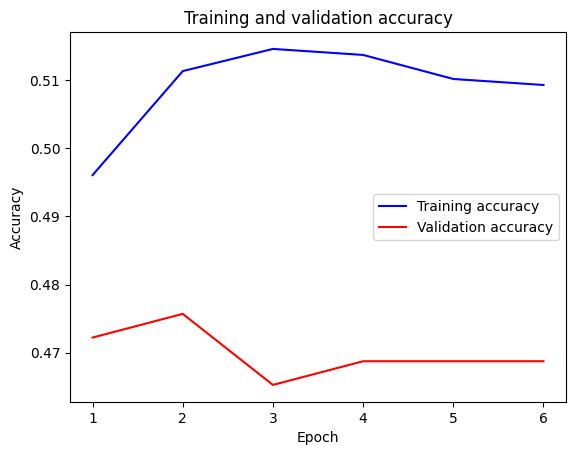

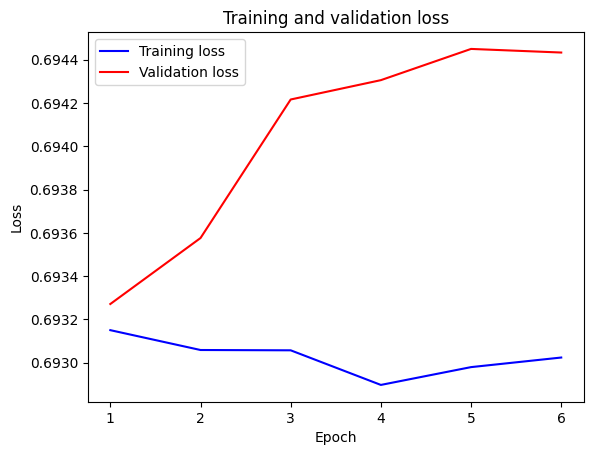

In [126]:
# Extracting training and validation accuracy and loss (model2_1)
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']


loss = history.history['loss']
val_loss = history.history['val_loss']


# Calculating the number of epochs
epochs = range(1, len(accuracy) + 1)

# Plotting accuracy
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Model 3: Pre-trained MobileNet V2

In [111]:
# Evaluate the trained model on the test set (run this when already done training)
model3 = load_model('MobileNetV2_condition2_2.h5')
test_loss, test_accuracy = model3.evaluate(test_generator)

# # Evaluate the model on the test set
# test_loss, test_accuracy = model2_2.evaluate(test_generator)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

12/12 [==============================] - 6s 446ms/step - loss: 0.0828 - accuracy: 0.9644
Test Loss: 0.0828077644109726
Test Accuracy: 0.9643835425376892


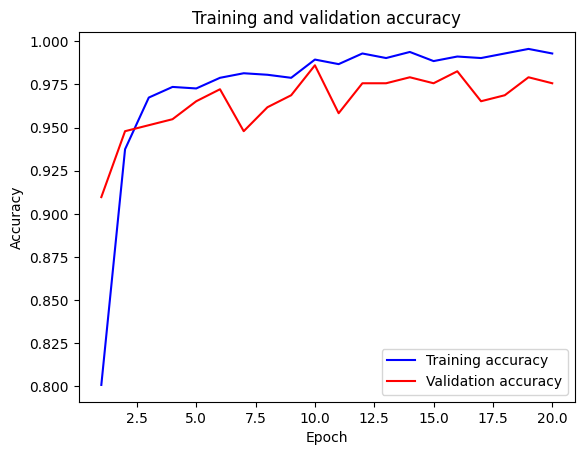

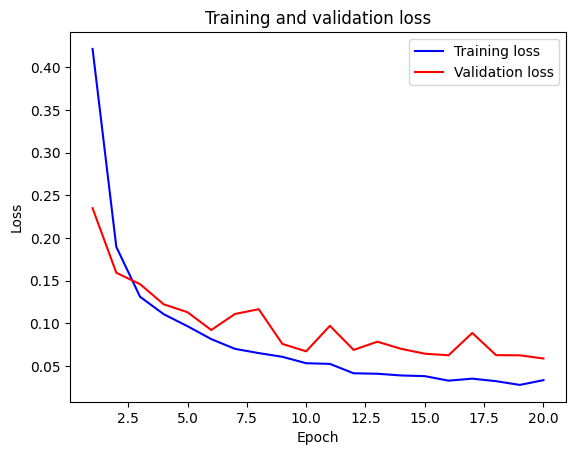

In [106]:
# Extracting training and validation accuracy and loss (model2_2)
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']


loss = history.history['loss']
val_loss = history.history['val_loss']


# Calculating the number of epochs
epochs = range(1, len(accuracy) + 1)

# Plotting accuracy
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Model Testing

## Model 1: Custom CNN

In [120]:
# Predict the label of the test_images
probs = model1.predict(test_generator)
pred = np.argmax(probs,axis=1)

# Map the label
labels = (train_generator.class_indices) 
labels = dict((v,k) for k,v in labels.items()) # {0: 'fresh', 1: 'rotten'}
pred_labels = [labels[k] for k in pred]

12/12 [==============================] - 5s 368ms/step


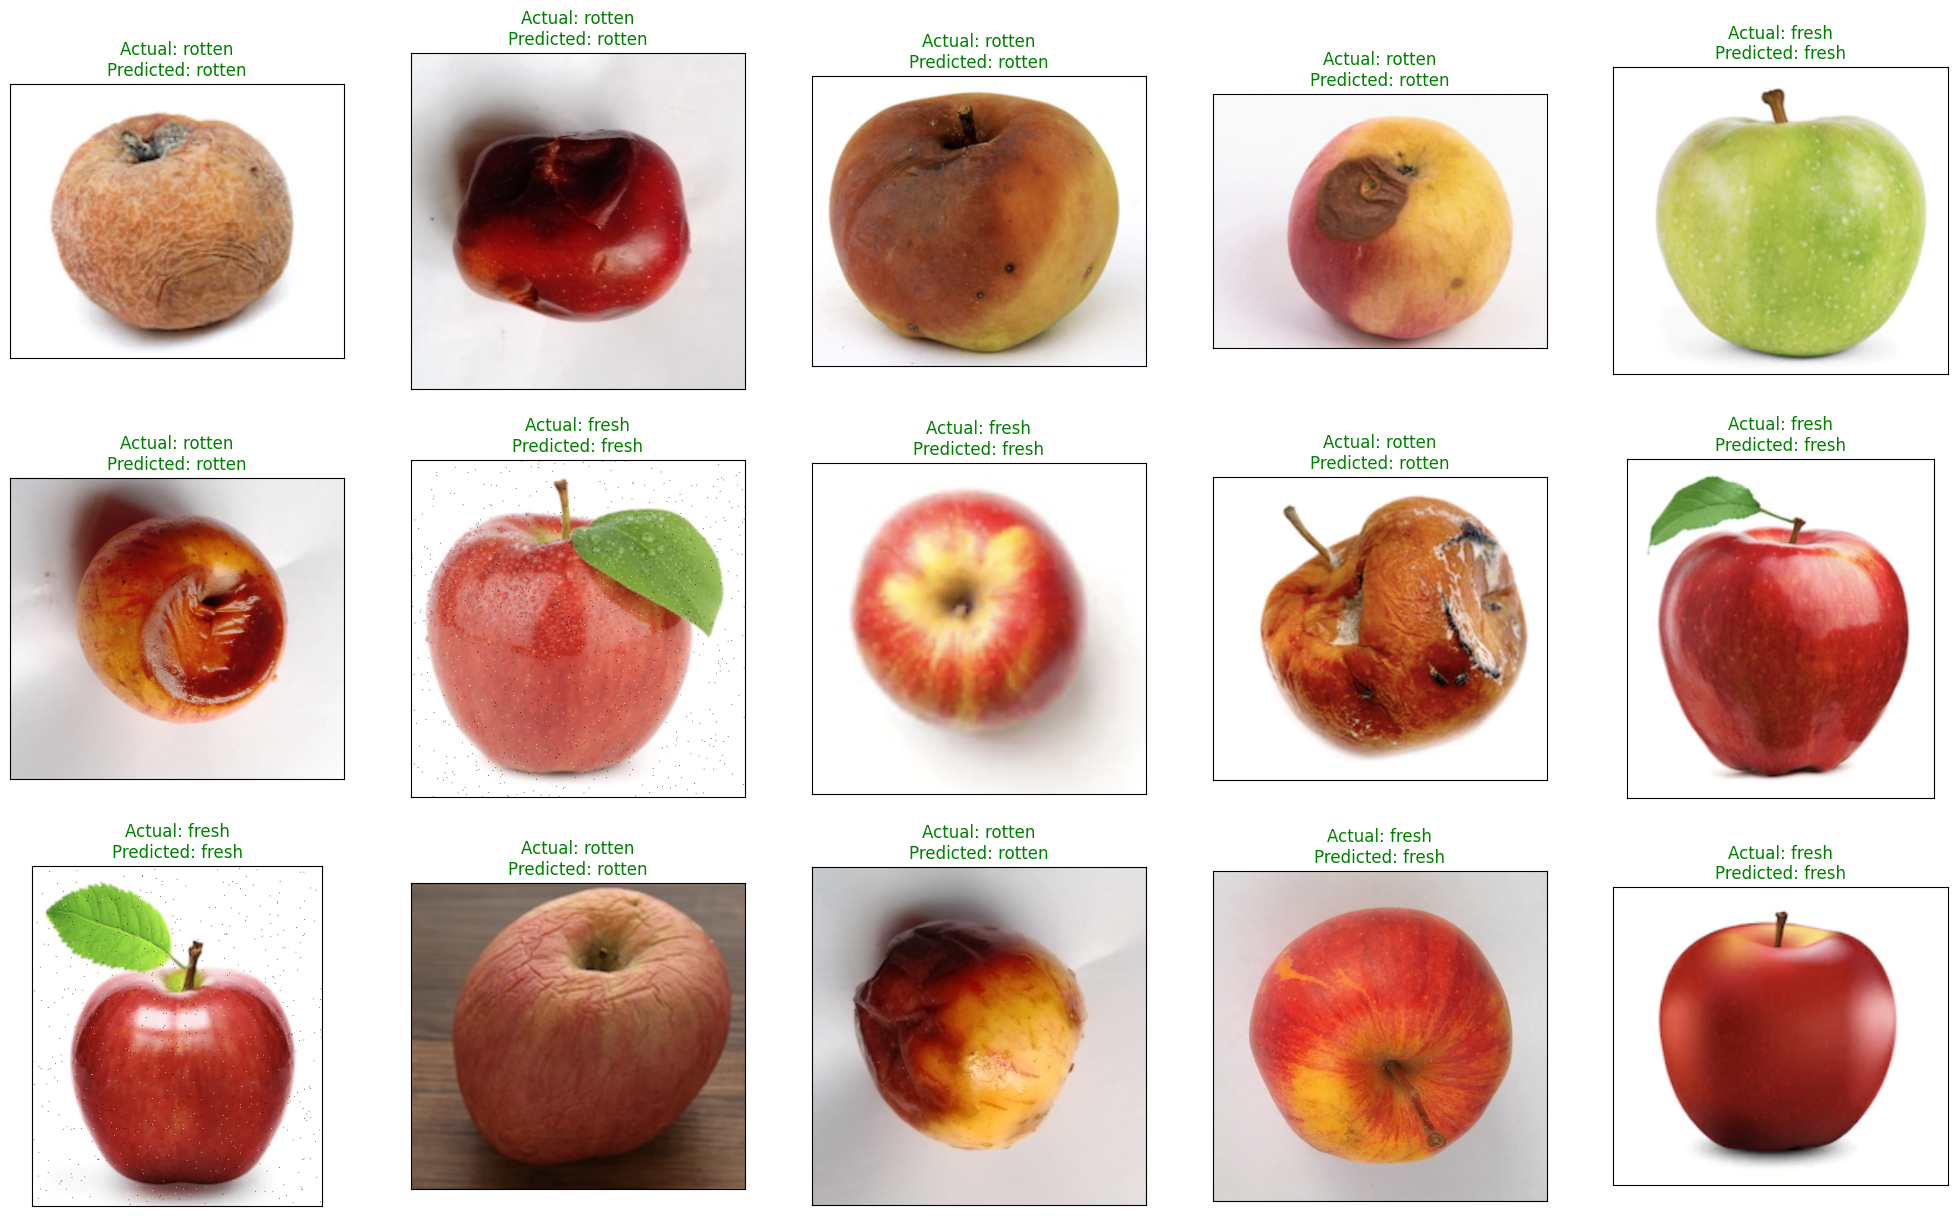

<Figure size 640x480 with 0 Axes>

In [121]:
# Display 15 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred_labels[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"Actual: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred_labels[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

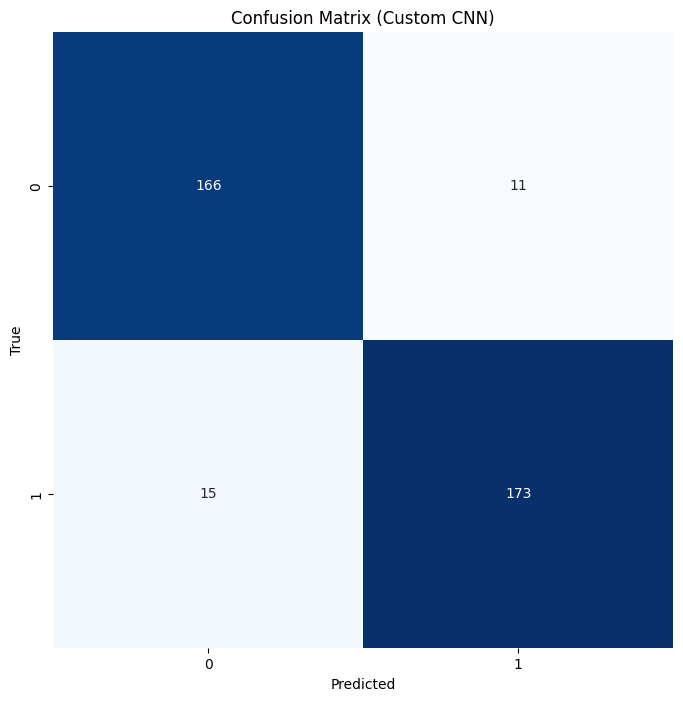

              precision    recall  f1-score   support

       fresh       0.92      0.94      0.93       177
      rotten       0.94      0.92      0.93       188

    accuracy                           0.93       365
   macro avg       0.93      0.93      0.93       365
weighted avg       0.93      0.93      0.93       365



In [122]:
# Get true labels from the test generator
actual = test_generator.classes

# Plot confusion matrix
cm = confusion_matrix(actual, pred)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Custom CNN)')
plt.show()

# Print classification report
class_labels = list(test_generator.class_indices.keys())
print(classification_report(actual, pred, target_names=class_labels))

## Model 2: MobileNet V2

In [127]:
# Predict the label of the test_images
probs2 = model2.predict(test_generator)
pred2 = np.argmax(probs2,axis=1)

# Map the label
labels2 = (train_generator.class_indices) 
labels2 = dict((v,k) for k,v in labels2.items()) # {0: 'fresh', 1: 'rotten'}
pred_labels2 = [labels2[k] for k in pred2]

12/12 [==============================] - 6s 445ms/step


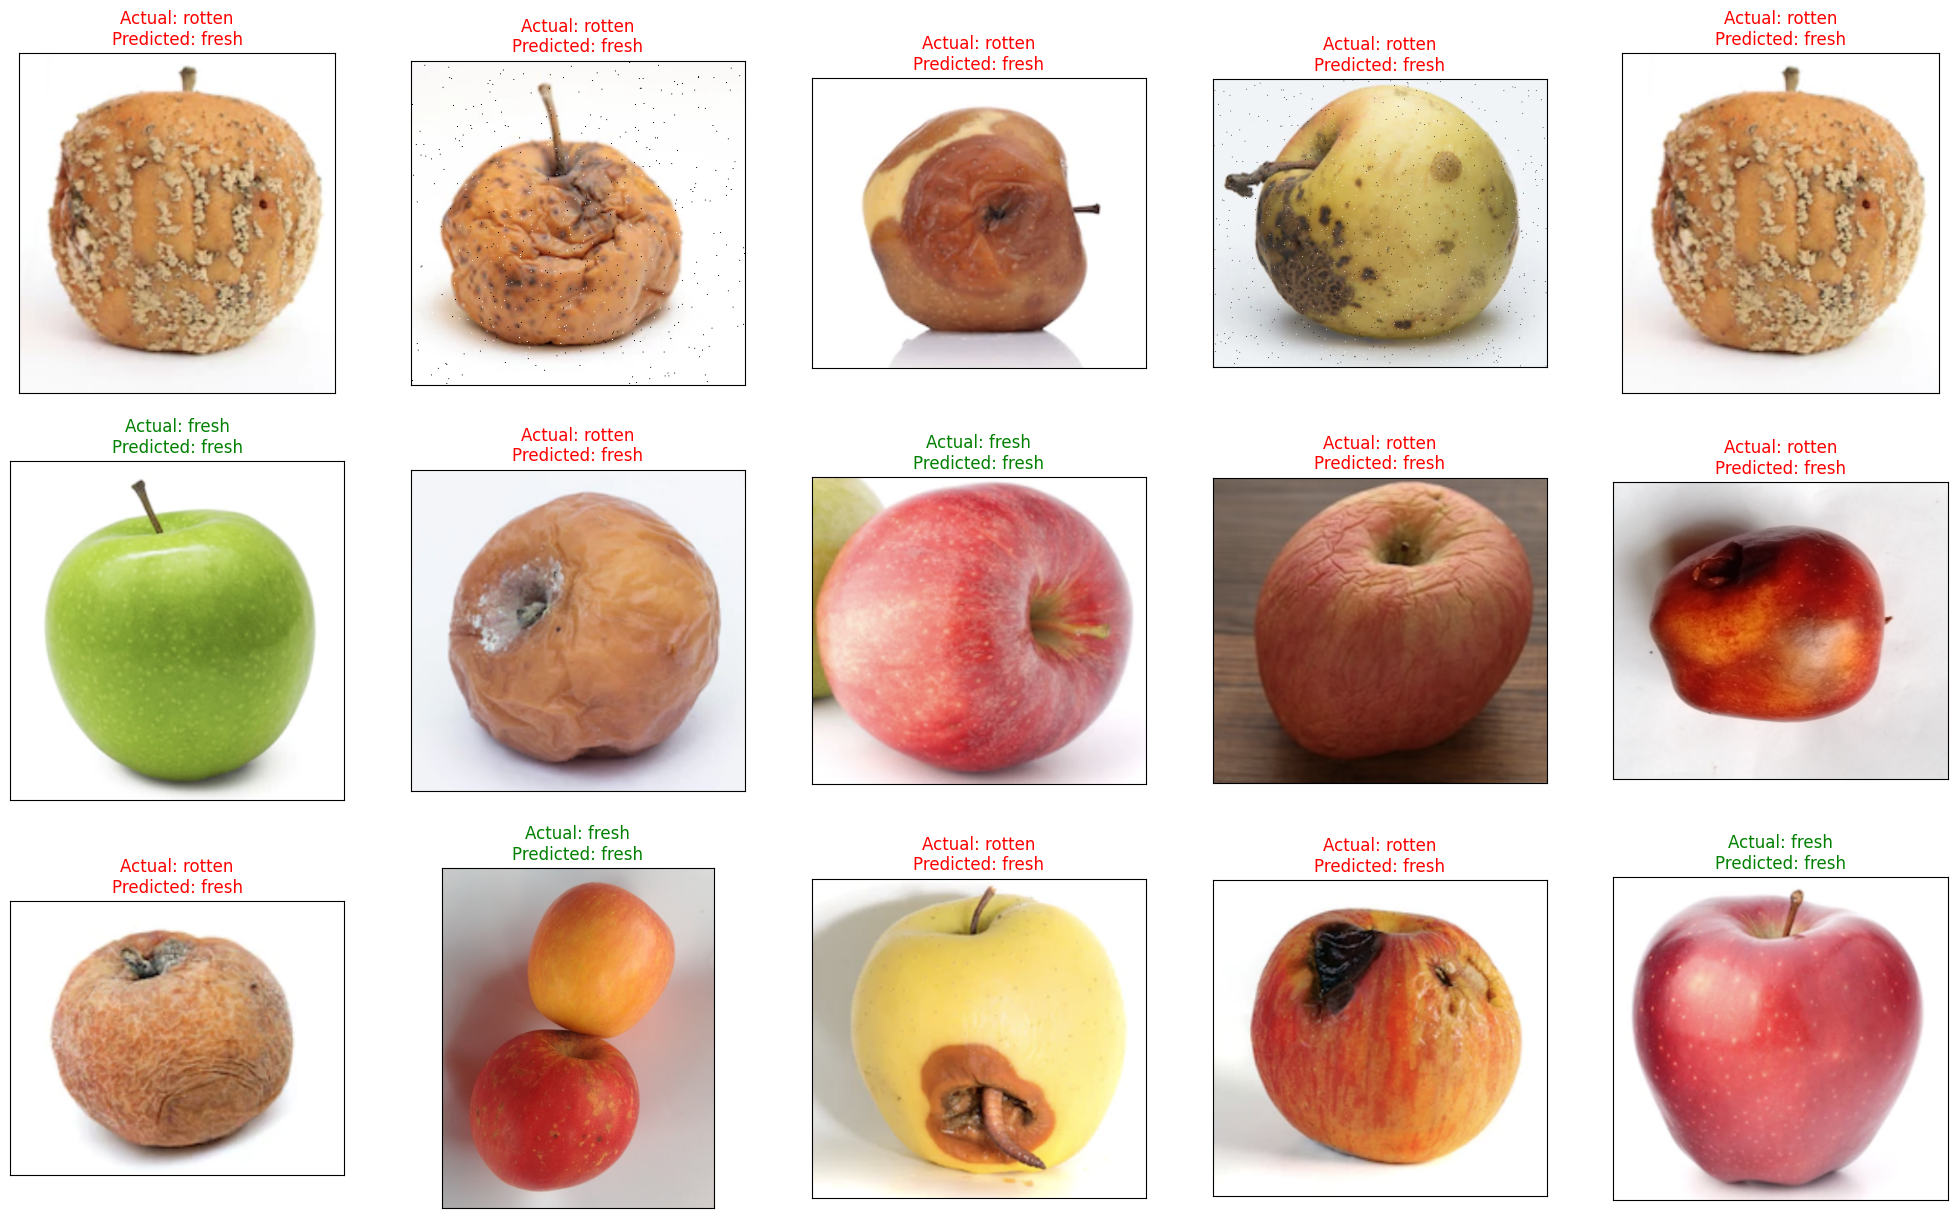

<Figure size 640x480 with 0 Axes>

In [128]:
# Display 15 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred_labels2[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"Actual: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred_labels2[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

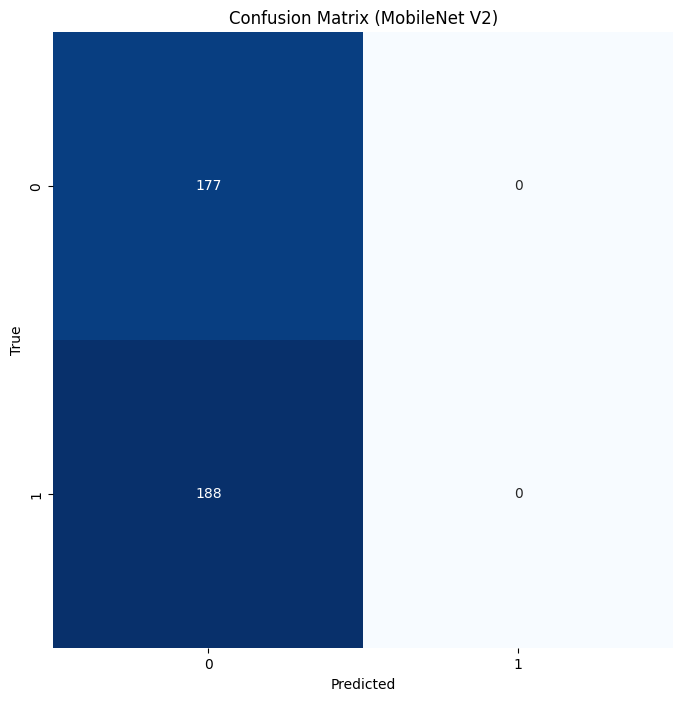

              precision    recall  f1-score   support

       fresh       0.48      1.00      0.65       177
      rotten       0.00      0.00      0.00       188

    accuracy                           0.48       365
   macro avg       0.24      0.50      0.33       365
weighted avg       0.24      0.48      0.32       365



C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [129]:
# Get true labels from the test generator
actual = test_generator.classes

# Plot confusion matrix
cm = confusion_matrix(actual, pred2)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (MobileNet V2)')
plt.show()

# Print classification report
class_labels = list(test_generator.class_indices.keys())
print(classification_report(actual, pred2, target_names=class_labels))

## Model 3: Pre-trained MobileNet V2

In [112]:
# Predict the label of the test_images
probs3 = model3.predict(test_generator)
pred3 = np.argmax(probs3,axis=1)

# Map the label
labels3 = (train_generator.class_indices) 
labels3 = dict((v,k) for k,v in labels3.items()) # {0: 'fresh', 1: 'rotten'}
pred_labels3 = [labels3[k] for k in pred3]

12/12 [==============================] - 6s 454ms/step


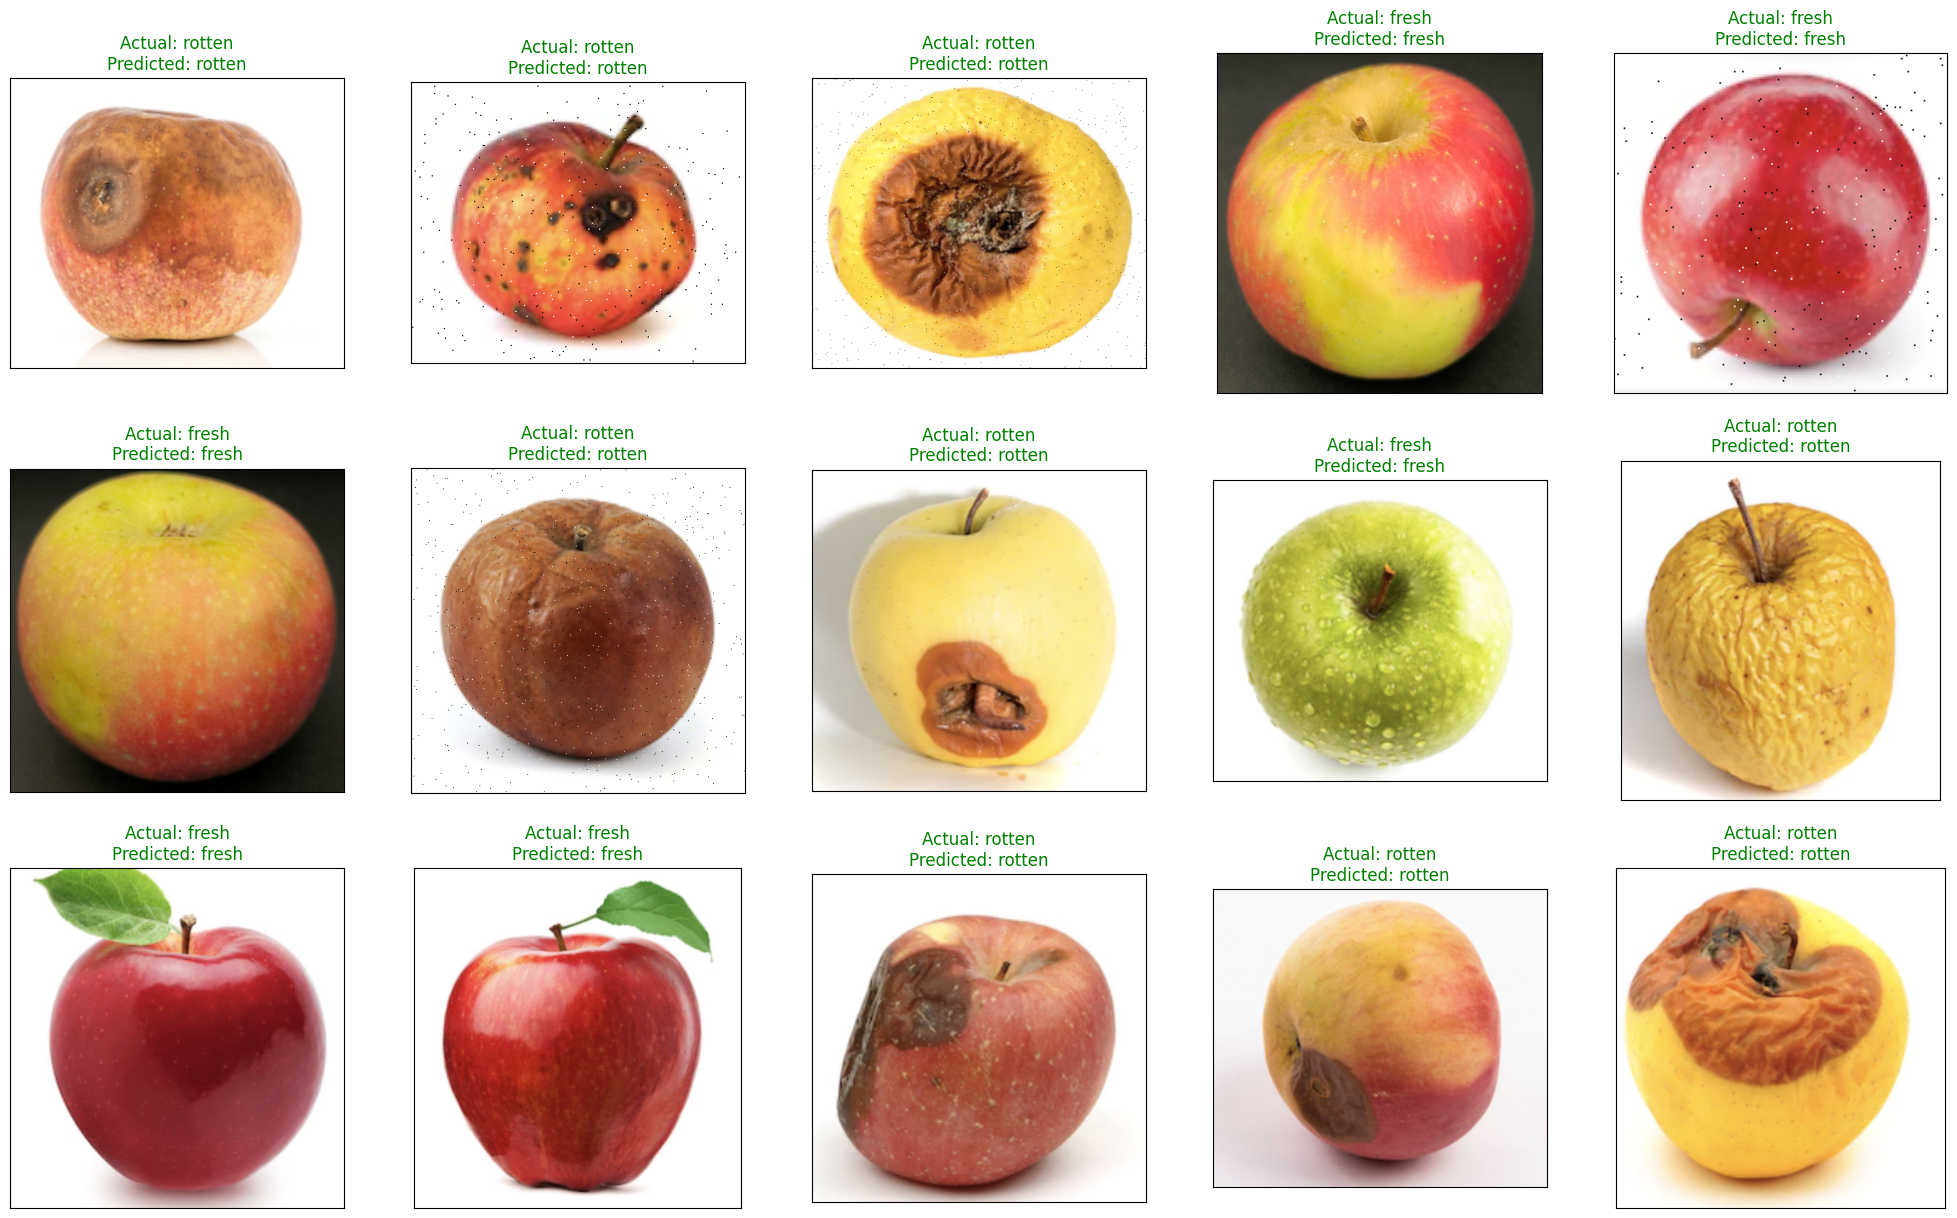

<Figure size 640x480 with 0 Axes>

In [113]:
# Display 15 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred_labels3[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"Actual: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred_labels3[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

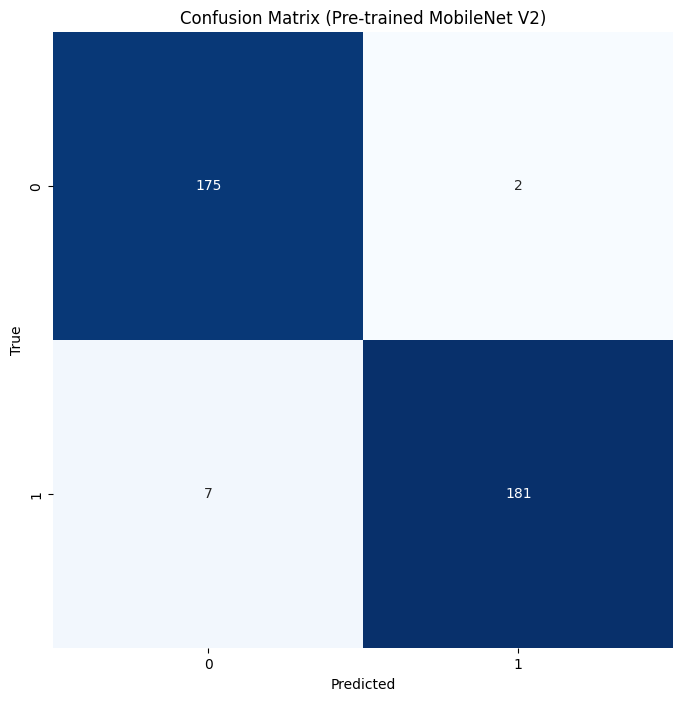

              precision    recall  f1-score   support

       fresh       0.96      0.99      0.97       177
      rotten       0.99      0.96      0.98       188

    accuracy                           0.98       365
   macro avg       0.98      0.98      0.98       365
weighted avg       0.98      0.98      0.98       365



In [114]:
# Get true labels from the test generator
actual = test_generator.classes

# Plot confusion matrix
cm = confusion_matrix(actual, pred3)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Pre-trained MobileNet V2)')
plt.show()

# Print classification report
class_labels = list(test_generator.class_indices.keys())
print(classification_report(actual, pred3, target_names=class_labels))

## Real world testing

1/1 [==============================] - 0s 68ms/step


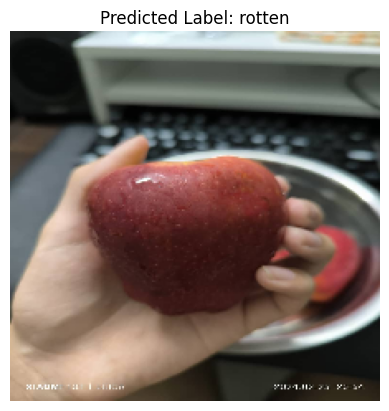

In [130]:
# Load and preprocess the image
img_path = 'testing/t1.jpg'
img = image.load_img(img_path, target_size=(224, 224))  # Adjust target_size as needed
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.  # Normalize pixel values

# Predict the label
probs = model1.predict(img_array)
pred_label_idx = np.argmax(probs)
pred_label = labels[pred_label_idx]

# Display the image and predicted label
plt.imshow(img)
plt.title(f'Predicted Label: {pred_label}')
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 481ms/step


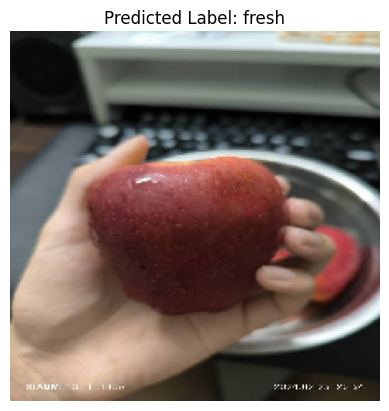

In [131]:
# Load and preprocess the image
img_path = 'testing/t1.jpg'
img = image.load_img(img_path, target_size=(224, 224))  # Adjust target_size as needed
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.  # Normalize pixel values

# Predict the label
probs = model2.predict(img_array)
pred_label_idx = np.argmax(probs)
pred_label = labels[pred_label_idx]

# Display the image and predicted label
plt.imshow(img)
plt.title(f'Predicted Label: {pred_label}')
plt.axis('off')
plt.show()

1/1 [==============================] - 1s 610ms/step


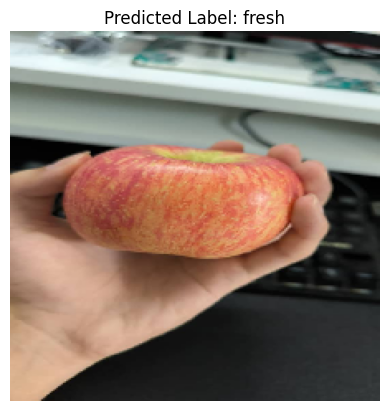

In [110]:
# Load and preprocess the image
img_path = 'testing/t2.jpg'
img = image.load_img(img_path, target_size=(224, 224))  # Adjust target_size as needed
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.  # Normalize pixel values

# Predict the label
probs = model3.predict(img_array)
pred_label_idx = np.argmax(probs)
pred_label = labels[pred_label_idx]

# Display the image and predicted label
plt.imshow(img)
plt.title(f'Predicted Label: {pred_label}')
plt.axis('off')
plt.show()